# Week 7: Deep Image Registration

## D2-Net Implementation
### Requirements
Firstly, here are the necessary imports only for this Notebook:

In [3]:
!pip install pytorch
!pip install numpy
!pip install wget
!pip install scikit-image
!pip install cudatoolkit=10.0
!pip install imageio

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
Using legacy 'setup.py install' for pytorch, since package 'wheel' is not installed.
    Running setup.py install for pytorch ... error
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/_g/k_05khhx1h91t46fn8d58p8w0000gn/T/pip-install-eppmf906/pytorch_dee1e22ced884536b2f8e8095d133e97/setup.py'"'"'; __file__='"'"'/private/var/folders/_g/k_05khhx1h91t46fn8d58p8w0000gn/T/pip-install-eppmf906/pytorch_dee1e22ced884536b2f8e8095d133e97/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/_g/k_05khhx1h91t46fn8d58p8w0000gn/T/pip-r

In [5]:
!pip install torch

     |████████████████████████████████| 119.5 MB 62 kB/s  eta 0:00:01   |                                | 348 kB 2.5 MB/s eta 0:00:48     |███▉                            | 14.3 MB 1.8 MB/s eta 0:00:58     |██████████▍                     | 38.9 MB 5.7 MB/s eta 0:00:15     |███████████                     | 41.0 MB 3.3 MB/s eta 0:00:24     |███████████                     | 41.4 MB 3.3 MB/s eta 0:00:24     |███████████▏                    | 41.7 MB 3.3 MB/s eta 0:00:24     |███████████████▌                | 57.8 MB 3.7 MB/s eta 0:00:17     |██████████████████████▎         | 83.1 MB 2.6 MB/s eta 0:00:14     |███████████████████████▉        | 89.2 MB 1.9 MB/s eta 0:00:16     |█████████████████████████▊      | 95.9 MB 3.6 MB/s eta 0:00:07     |███████████████████████████████▍| 117.3 MB 3.4 MB/s eta 0:00:01


In [8]:
!python -m pip install -U scikit-image

    100% |████████████████████████████████| 29.8MB 446kB/s ta 0:00:01   22% |███████                         | 6.6MB 2.1MB/s eta 0:00:11    51% |████████████████▌               | 15.4MB 513kB/s eta 0:00:29    97% |███████████████████████████████▏| 29.0MB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 153kB 3.2MB/s ta 0:00:01
    100% |████████████████████████████████| 4.3MB 2.0MB/s ta 0:00:01
  Stored in directory: /Users/HEY/Library/Caches/pip/wheels/59/95/cc/5a9c2cd844519053210dc9566ba656a7fbec625b3abf59fb74
Successfully built scikit-image


In [12]:
!pip install scikit-image

In [13]:
import os

import numpy as np

import imageio

import torch

import scipy
import scipy.io
import scipy.misc

from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform

import matplotlib.pyplot as plt

import re

import cv2

from PIL import Image

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/geometry.cpython-37m-darwin.so, 2): Symbol not found: ____chkstk_darwin
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/../.dylibs/libomp.dylib
  Expected in: /usr/lib/libSystem.B.dylib
 in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/../.dylibs/libomp.dylib
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/install.html 

For the implementation of D2-Net we also clone the D2-Net [repository](https://github.com/mihaidusmanu/d2-net) from Mihai Dusmanu.  
If you run into any errors running the following line you can also manually download the repository and save the root folder of it as ``d2-net``.  

In [14]:
# Cloning the GitHub repository
!git clone https://github.com/mihaidusmanu/d2-net

fatal: destination path 'd2-net' already exists and is not an empty directory.


We also download the pretrained weights for the model.  

In [15]:
# Downloading and storing the pretrained weights in d2-net/models
!mkdir "./models"
!python -m wget https://dsmn.ml/files/d2-net/d2_ots.pth -o "./models/d2_ots.pth"
!python -m wget https://dsmn.ml/files/d2-net/d2_tf.pth -o "./models/d2_tf.pth"
!python -m wget https://dsmn.ml/files/d2-net/d2_tf_no_phototourism.pth -o "./models/d2_tf_no_phototourism.pth"

mkdir: ./models: File exists
100% [....................................................] 30545768 / 30545768
Saved under ./models/d2_ots (1).pth
100% [....................................................] 30545768 / 30545768
Saved under ./models/d2_tf (1).pth
100% [....................................................] 30545747 / 30545747
Saved under ./models/d2_tf_no_phototourism (1).pth


Since we want to show how the model operates we want to download and process a dataset.  
For this purpose we chose the W1BS dataset.  

In [16]:
!python -m wget http://icvl.ee.ic.ac.uk/vbalnt/hpatches/hpatches-sequences-release.tar.gz -o "d2-net/hpatches_sequences/"

 77% [.....................................           ]  988372992 / 1279780913200 / 1279780913856 / 1279780913^C
Traceback (most recent call last):
  File "/Users/HEY/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/HEY/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/HEY/anaconda3/lib/python3.6/site-packages/wget.py", line 568, in <module>
    filename = download(args[0], out=options.output)
  File "/Users/HEY/anaconda3/lib/python3.6/site-packages/wget.py", line 526, in download
    (tmpfile, headers) = ulib.urlretrieve(binurl, tmpfile, callback)
  File "/Users/HEY/anaconda3/lib/python3.6/urllib/request.py", line 277, in urlretrieve
    block = fp.read(bs)
  File "/Users/HEY/anaconda3/lib/python3.6/http/client.py", line 449, in read
    n = self.readinto(b)
  File "/Users/HEY/anaconda3/lib/python3.6/http/client.py", line 493, in readinto
    n = self.fp.readinto(b)
  File "/

In [1]:
!python -m wget http://cmp.felk.cvut.cz/wbs/datasets/W1BS_with_patches.tar.gz -o "./"
!tar -xzf "./W1BS_with_patches.tar.gz"

### Overview (work in progress)
The core idea of the D2-Net source code is to include image pairs in the folder ``./qualitative/images/`` as folders with two images ``1.jpg`` and ``2.jpg``.  
Then the feature extractor is run on a list of paths to these images by giving the argument ``--image_list_file file.txt`` when running the feature extractor script.  
...  
Then, as demonstrated in ``./qualitative/Qualitative-Matches.ipynb``, the images can be plotted to show the keypoints after loading the extracted features and the images.  

We now create a image list text document to later be used to run the ``extract_features.py`` script with.  
For this we need to test which images are usable from the dataset and which are not first.  
The two following code blocks are used for this purpose.  
The ``preprocessable`` function is written by taking all image processing relatable code from ``d2-net/feature_extractor.py`` and ``d2-net/lib/utils.py``.

In [17]:
def preprocessable(path) -> bool:
    '''This function test if a given image (as path) is preprocessable by d2-net/lib/utils/preprocessing.'''
    try:
        image = imageio.imread(path)
        if len(image.shape) == 2:
            image = image[:, :, np.newaxis]
            image = np.repeat(image, 3, -1)

        resized_image = image
        if max(resized_image.shape) > 1600:
            resized_image = scipy.misc.imresize(resized_image,1600 / max(resized_image.shape)).astype('float')
        if sum(resized_image.shape[: 2]) > 2800:
            resized_image = scipy.misc.imresize(resized_image,2800 / sum(resized_image.shape[: 2])).astype('float')

        image = image.astype(np.float32)
        image = np.transpose(image, [2, 0, 1])

        image /= 255.0
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean.reshape([3, 1, 1])) / std.reshape([3, 1, 1])
        return True
    except:
        return False

The following line will print a warning for scipy, we are using a version older than 1.3.0 however, meaning that there will not be an error yet (see environment).  

In [18]:
# A for loop will get all .png files from the dataset and test preprocessability
image_files = []
if not os.path.exists('./W1BS/image_list.txt'):
    path_prfx = './W1BS'
    for folder in os.listdir(path_prfx):
        for subfolder in os.listdir(path_prfx+'/'+folder):
            for file in os.listdir(path_prfx+'/'+folder+'/'+subfolder):
                if '.png' in file:
                    if preprocessable(path_prfx+'/'+folder+'/'+subfolder+'/'+file):
                        image_files += [path_prfx+'/'+folder+'/'+subfolder+'/'+file]
else:
    print('The file has already been created.')
                
# Now we create the .txt file:
if not os.path.exists('./W1BS/image_list.txt'):
    with open('./W1BS/image_list.txt','w') as f:
        for path in image_files:
            f.write(path+'\n')
            print('Successfully created image_list.txt file.')

NotADirectoryError: [Errno 20] Not a directory: './W1BS/.DS_Store'

Now we perform feature extraction three times with the different model weights which we have downloaded before.  
Feel free to only run one or two if you like, but make sure you only try to plot or evaluate the models you have the features loaded with.  

In [19]:
models_loaded = []

In [20]:
models_loaded.append('standard')
!python "d2-net/extract_features.py" --image_list_file "./W1BS/image_list.txt" --preprocessing "torch"

Traceback (most recent call last):
  File "d2-net/extract_features.py", line 7, in <module>
    import torch
  File "/Users/HEY/anaconda3/lib/python3.6/site-packages/torch/__init__.py", line 190, in <module>
    from torch._C import *
ImportError: dlopen(/Users/HEY/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libtorch_cpu.dylib
  Referenced from: /Users/HEY/anaconda3/lib/python3.6/site-packages/torch/lib/libtorch_python.dylib
  Reason: image not found


In [53]:
models_loaded.append('d2_ots')
!python "d2-net/extract_features.py" --image_list_file "./W1BS/image_list.txt" --preprocessing "torch" --model_file "./models/d2_ots.pth" --output_extension ".d2-net_ots"

Namespace(image_list_file='./W1BS/image_list.txt', max_edge=1600, max_sum_edges=2800, model_file='./models/d2_ots.pth', multiscale=False, output_extension='.d2-net_ots', output_type='npz', preprocessing='torch', use_relu=True)



100%|##########| 78/78 [08:16<00:00,  6.37s/it]


In [54]:
models_loaded.append('nophototourism')
!python "d2-net/extract_features.py" --image_list_file "./W1BS/image_list.txt" --preprocessing "torch" --model_file "./models/d2_tf_no_phototourism.pth" --output_extension ".d2-net_npt"

Namespace(image_list_file='./W1BS/image_list.txt', max_edge=1600, max_sum_edges=2800, model_file='./models/d2_tf_no_phototourism.pth', multiscale=False, output_extension='.d2-net_npt', output_type='npz', preprocessing='torch', use_relu=True)



100%|##########| 78/78 [08:29<00:00,  6.54s/it]


In [61]:
class W1BSMatcher:
    '''A class specified for plotting images from the W1BS dataset'''
    def __init__(self, models_loaded):
        self._image_paths = []
        try:
            with open('./W1BS/image_list.txt','r') as f:
                self._image_paths = f.read().split('\n')
        except Exception as e:
            print(e)
            
        self._images = set([re.search(r'(/)([\w\d]+)(.png)',self._image_paths[i])[0][1:-4] 
                            for i in range(len(self._image_paths)) 
                            if re.search(r'(/)([\w\d]+)(.png)',self._image_paths[i]) != None])
        
        self._models = models_loaded
        
        self._extensions = {}
        if 'standard' in self._models:
            self._extensions['standard'] = '.d2-net'
        if 'nophototourism' in self._models:
            self._extensions['nophototourism'] = '.d2-net_npt'
        if 'd2_ots' in self._models:
            self._extensions['d2_ots'] = '.d2-net_ots'
    
    def compare_pair(self, name, model='standard'):
        '''This method performs qualitative plotting for an image pair and a loaded model.
Description:
    Having loaded in the features for a specific model, we can plot the image pair just as done in ./d2-net/qualitative/qualitative_matches.ipynb.
    This method takes in two arguments, one being the image pair from the loaded dataset which you want to plot, the other being which model weights should be used.
    The respective sets of possible parameters to use can be viewed as the attribute <self>.images and <self>.models.
Example:
    compare_pair('obama',model='nophototourism')
Arguments:
    images -> str: A string with the name of the image pair, as visible from the attribute set <self>.images
    model -> str: A string with the name of the model which's features shall be evaluated, as visible from the attribute set <self>.models.
    '''
        # Checks if the requested model has been used to extract yet
        if not model in self._models:
            return 'The requested features have not been extracted yet.'
        
        # Checks if the selected image pair exists in the dataset
        if not name in list(self._images):
            return 'The selected image is not part of the dataset, you can view all available images in the attribute <self>.images'
        
        # We find the two paths leading to the image pair
        paths = [path for path in self._image_paths if '/'+name+'.png' in path]
        if len(paths) > 2:
            return 'Something went wrong as more than two images were found, please check if your directory was created correctly.'
        
        # Here we load in the images and the features that have been extracted from the image
        image1 = np.array(Image.open(paths[0]))
        image2 = np.array(Image.open(paths[1]))
        feat1 = np.load(paths[0]+self._extensions[model])
        feat2 = np.load(paths[1]+self._extensions[model])
        
        # This following code has been copied from ./d2-net/qualitative/qualitative_matches.ipynb
        matches = match_descriptors(feat1['descriptors'], feat2['descriptors'], cross_check=True)
        print('Number of raw matches: %d.' % matches.shape[0])
        
        keypoints_left = feat1['keypoints'][matches[:, 0], : 2]
        keypoints_right = feat2['keypoints'][matches[:, 1], : 2]
        np.random.seed(0)
        model, inliers = ransac(
            (keypoints_left, keypoints_right),
            ProjectiveTransform, min_samples=4,
            residual_threshold=4, max_trials=10000
        )
        n_inliers = np.sum(inliers)
        print('Number of inliers: %d.' % n_inliers)
        
        inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
        inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
        placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
        image3 = cv2.drawMatches(image1, inlier_keypoints_left, image2, inlier_keypoints_right, placeholder_matches, None)

        plt.figure(figsize=(15, 15))
        plt.imshow(image3)
        plt.axis('off')
        plt.show()
        
    @property
    def images(self):
        '''A list of image pairs included in the dataset.'''
        return self._images
    
    @property
    def models(self):
        '''A list of models with which feature extraction has been completed.'''
        return self._models

In [62]:
matcher = W1BSMatcher(models_loaded)

Here you can see possible parameters for the method ``compare_pair``:

In [63]:
print(matcher.images)

{'trevi', 'ExtremeZoomA', 'map4', 'map5', 'paintedladies', 'vprice0', 'GC2', 'bdom', 'madrid', 'shop', 'angiogram', 'treebranch', 'map6', 'adam', 'mms75', 'light', 'arch', 'face', 'amos1', 'vatican', 'graf', 'brugge_square', 'map1', 'vprice1', 'vprice2', 'notredame15', 'mms68', 'vin', 'fox', 'map3', 'rushmore', 'there', 'brain1', 'map2', 'mag', 'yosemite', 'obama', 'boat'}


In [64]:
print(matcher.models)

['d2_ots', 'nophototourism', 'standard']


Here you can test around with plotting the image pairs and view the qualitative results of the model's extracted features:

Number of raw matches: 248.
Number of inliers: 7.


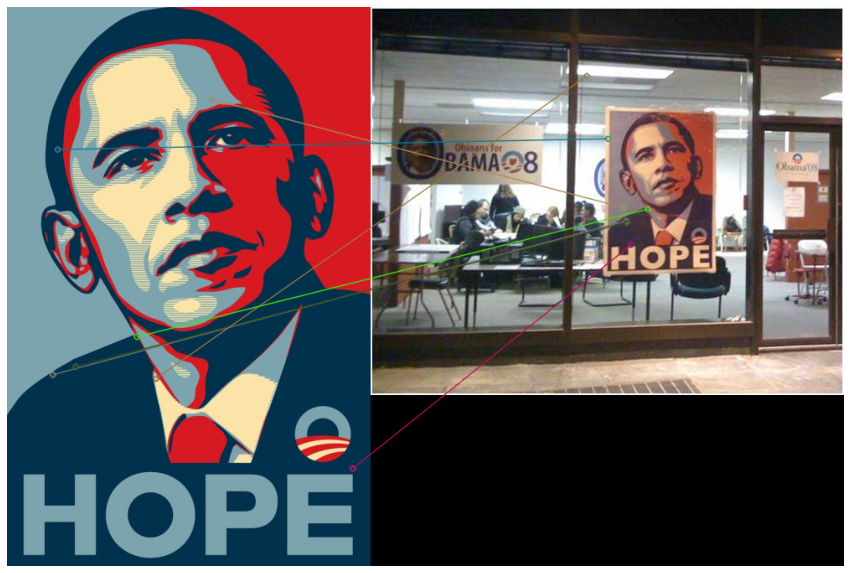

In [67]:
matcher.compare_pair('obama')

Number of raw matches: 240.
Number of inliers: 7.


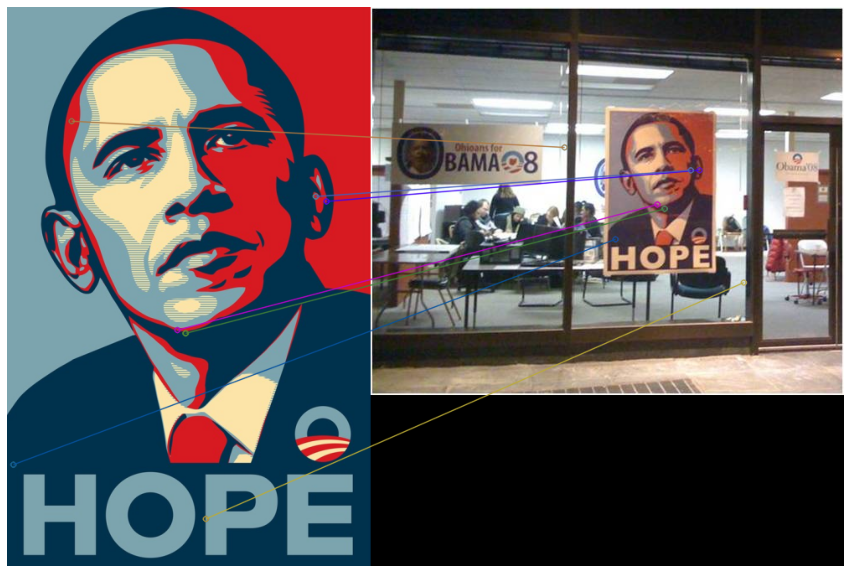

In [68]:
matcher.compare_pair('obama', model='nophototourism')